In [51]:
import os
import geopandas as gpd
import pandas as pd
import json
import json_stream.requests
import ijson

import requests
import folium

import asyncio
import aiohttp

from dotenv import load_dotenv
from ckanapi import RemoteCKAN

import warnings
url = "https://data-nifc.opendata.arcgis.com/datasets/nifc::historic-perimeters-combined-2000-2018-geomac.geojson?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D"

In [ ]:
def extract_geometries(data):
    return {
        "type": "FeatureCollection",
        "features": [
            {"type": "Feature", "geometry": feature["geometry"]}
            for feature in data.get("features", [])[:100]
        ]
    }

In [62]:
ckan = RemoteCKAN('https://wifire-data.sdsc.edu/', apikey=os.environ['apiKey'])

In [105]:
ckan = RemoteCKAN('https://wifire-data.sdsc.edu/', apikey=os.environ['apiKey'])
search = ''
title_query = f'title:{search}'
# res_format:"Esri REST" OR res_format:"ArcGIS GeoServices REST API"
normal_query = f'title:"{search}" AND (res_format:"Esri REST" OR res_format:"ArcGIS GeoServices REST API" OR res_format:GeoJSON OR res_format:GeoTIFF OR res_format:TIFF)'
params = {
    'q':normal_query,
    'start': 0,
    'rows': 100
}
# response = ckan.action.package_search(q=search, fq='res_format:GeoTIFF OR res_format:GeoJSON', start=0, rows=100)
response = ckan.action.package_search(**params)
results = response['results']
print(f'{len(results)} results')
# filtered_results = [
#     result for result in results
#     if (
#         'GeoTIFF' in [resource['format'] for resource in result['resources']]
#         # 'GeoJSON' in [resource['format'] for resource in result['resources']]
#     )
# ]
# print(f'filtered results, {len(filtered_results)} remaining')
for result in results:
    print(result['title'])
    resources = result['resources']
    for resource in resources:
        print('    ', resource['format'], resource['url'])

100 results
NIFC Open Data Site Participation
     HTML https://data-nifc.opendata.arcgis.com/documents/nifc::nifc-open-data-site-participation
     ArcGIS GeoServices REST API 
WFIGS
     HTML https://data-nifc.opendata.arcgis.com/pages/wfigs-page
     ArcGIS GeoServices REST API 
New FireHistory Services
     HTML https://data-nifc.opendata.arcgis.com/pages/new_firehistory_services
     ArcGIS GeoServices REST API 
Historic GeoMAC Perimeters 2019
     HTML https://data-nifc.opendata.arcgis.com/datasets/nifc::historic-geomac-perimeters-2019
     ArcGIS GeoServices REST API 
#2023 GeoOps Folder Structure (Folders, GDBs, and layer files)
     HTML https://data-nifc.opendata.arcgis.com/datasets/nifc::2023-geoops-folder-structure-folders-gdbs-and-layer-files
     ArcGIS GeoServices REST API 
Public View - Interagency Remote Automatic Weather Stations (RAWS)
     HTML https://data-nifc.opendata.arcgis.com/maps/nifc::public-view-interagency-remote-automatic-weather-stations-raws
     ArcGIS

In [118]:
fetch_all_features('https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/National_PSA_Current/FeatureServer/0')

{'error': {'code': 400, 'message': '', 'details': ['The requested layer (layerId: 0) was not found.']}}


""


In [117]:
import urllib.request
import concurrent.futures
def fetch_all_features(base_url):
    if base_url[-1] not in '01234567889':
        return gpd.GeoDataFrame()
    # Get record extract limit
    url_string = base_url + "?f=json"
    j = urllib.request.urlopen(url_string)
    js = json.load(j)
    if 'error' in js:
        return gpd.GeoDataFrame()
    max_records_count = int(js["maxRecordCount"])
    # max_records_count = min(max_records_count, 800)
    # Get object ids of features
    fields = ""
    where = "1=1"
    url_string = base_url + "/query?where={}&returnIdsOnly=true&f=json".format(where)
    j = urllib.request.urlopen(url_string)
    js = json.load(j)
    id_field = js["objectIdFieldName"]
    id_list = js["objectIds"]
    # this could be optimized maybe
    id_list.sort()
    num_of_records = len(id_list)
    request_number = 0
    # create URLs for requests
    url_strings = []
    for i in range(0, num_of_records, max_records_count):
        request_number += 1
        to_rec = i + (max_records_count - 1)
        if to_rec > num_of_records:
            to_rec = num_of_records - 1
        from_id = id_list[i]
        to_id = id_list[to_rec]
        where = '{} BETWEEN {} AND {}'.format(id_field, from_id, to_id)
        url_string = base_url + "/query?where={}&returnGeometry=true&outFields={}&f=geojson".format(where, fields)
        url_strings.append(url_string)
    # specify helper function which does the fetching
    def load_features(urlstring):
        succeed = False
        while not succeed:
            try:
                with warnings.catch_warnings(action='ignore'):
                    resp = requests.get(urlstring, verify=False)
                data = resp.json()
                gdf = gpd.GeoDataFrame.from_features(data['features'], crs='EPSG:4326')
                gdf = gdf.loc[gdf['geometry'].is_valid, :]
                succeed = True
                return gdf
            except:
                print ('Failed to load {}'.format(urlstring))
    # thread pool to fetch features
    with concurrent.futures.ThreadPoolExecutor(max_workers=None) as executor:
        features_list = list(executor.map(load_features, url_strings))
    final_gdf = pd.concat(features_list)
    return final_gdf

# for result in results:
#     resources = result['resources']
#     for resource in resources:
#         if (resource['format']=='ArcGIS GeoServices REST API' or resource['format']=='Esri REST') and resource['url']:
#             print(result['title'], resource['url'])
#             print('   ', fetch_all_features(resource['url']).shape)

In [8]:
import folium
from io import BytesIO
import rasterio as rio
import matplotlib.pyplot as plt
from osgeo import gdal, ogr
import numpy as np
import numpy.ma as ma

In [9]:
response = requests.get(url)
raster_bytes = BytesIO(response.content)
with rio.open(raster_bytes) as src:
    data = src.read(1)
    nodata_value = src.nodata

In [10]:
data.shape, data.max(), data.min(), data.dtype, nodata_value

((16618, 17497), 0.431741, -3.4e+38, dtype('float32'), -3.3999999521443642e+38)

In [11]:
masked_data = ma.masked_array(data, nodata_value)

In [49]:
### this is the one!
import requests
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling, transform_bounds
from io import BytesIO

def fetch_raster_bytes(url):
    print(f'fetching data from {url}')
    response = requests.get(url)
    return BytesIO(response.content)

def create_raster_layer(dataset_name, raster_bytes, downsample_data=True):
    with rasterio.open(raster_bytes) as src:
        nodata_value = src.nodata
        src_crs = src.crs
        # reproject bounds to EPSG:4326
        src_bounds = src.bounds
        minx, miny, maxx, maxy = transform_bounds(src_crs, 'EPSG:4326', *src_bounds)
        layer_bounds = ((miny, minx), (maxy, maxx))
        print(f'reprojected bounds {layer_bounds}')

        # reproject data to EPSG:3857
        transform, width, height = calculate_default_transform(
            src_crs, 'EPSG:3857', src.width, src.height, *src.bounds)
        # reprojected_data = np.empty((src.count, height, width), dtype=src.dtypes[0])
        layers = []
        for i in range(1, src.count + 1):
            data = np.empty((height, width), dtype=src.dtypes[0])
            # reproject
            reproject(
                source=rasterio.band(src, i),
                destination=data,
                src_transform=src.transform,
                src_crs=src_crs,
                dst_transform=transform,
                dst_crs='EPSG:3857',
                resampling=Resampling.nearest
            )
            if downsample_data:
                data = data[::50, ::50]
            data[np.where(data==nodata_value)] = np.nan
            # create layer
            cmap = plt.get_cmap('viridis')
            norm = plt.Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))
            image_data = cmap(norm(data))
            alpha_channel = np.where(data > 0, 255, 0)
            rgba_image_data = np.dstack((image_data[:, :, :3] * 255, alpha_channel)).astype(np.uint8)
            img_overlay = folium.raster_layers.ImageOverlay(
                name=f"{dataset_name} Band {i}",
                image=rgba_image_data,
                bounds=layer_bounds,
                transparent=True,
                fmt="image/png8",
                tiled=True,
                interactive=True,
                cross_origin=False,
                zindex=1,
            )
            layers.append(img_overlay)
            print(f'    created layer for band {i}')
    return layers, data

def create_raster_layer(raster_bytes, dataset_name, downsample_data=True):
    with rasterio.open(raster_bytes) as src:
        nodata_value = src.nodata
        src_crs = src.crs
        # reproject bounds to EPSG:4326
        src_bounds = src.bounds
        minx, miny, maxx, maxy = transform_bounds(src_crs, 'EPSG:4326', *src_bounds)
        layer_bounds = ((miny, minx), (maxy, maxx))
        print(f'reprojected bounds {layer_bounds}')

        # reproject data to EPSG:3857
        transform, width, height = calculate_default_transform(
            src_crs, 'EPSG:3857', src.width, src.height, *src.bounds)
        # reprojected_data = np.empty((src.count, height, width), dtype=src.dtypes[0])

        data = np.empty((height, width), dtype=src.dtypes[0])
        # reproject
        reproject(
            source=rio.band(src, 1),
            destination=data,
            src_transform=src.transform,
            src_crs=src_crs,
            dst_transform=transform,
            dst_crs='EPSG:3857',
            resampling=Resampling.nearest
        )
        if downsample_data:
            data = data[::50, ::50]
        data[np.where(data==nodata_value)] = np.nan
        # create layer
        cmap = plt.get_cmap('viridis')
        norm = plt.Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))
        image_data = cmap(norm(data))
        alpha_channel = np.where(data > 0, 255, 0)
        rgba_image_data = np.dstack((image_data[:, :, :3] * 255, alpha_channel)).astype(np.uint8)
        raster_layer = folium.raster_layers.ImageOverlay(
            name=dataset_name,
            image=rgba_image_data,
            bounds=layer_bounds,
            transparent=True,
            fmt="image/png8",
            tiled=True,
            interactive=True,
            cross_origin=False,
            zindex=1,
        )
    return raster_layer

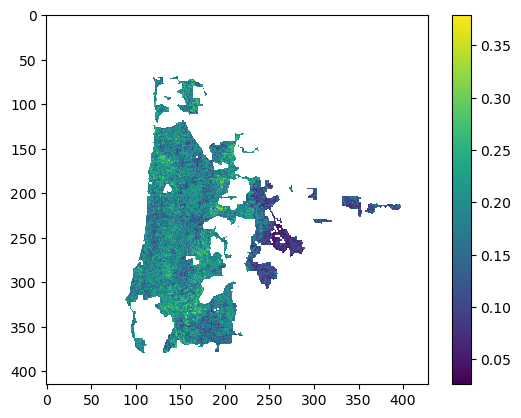

In [37]:
data[np.where(data==nodata_value)] = np.nan
plt.imshow(data)
plt.colorbar();

(nan, nan)

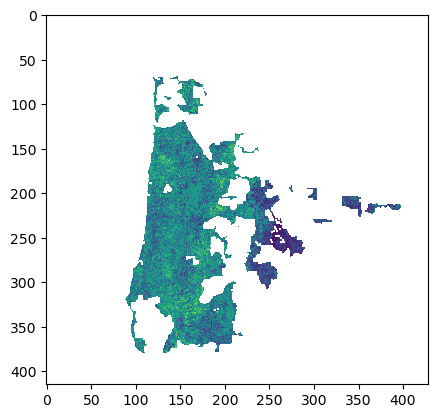

In [48]:
masked_data = np.ma.masked_equal(data, np.nan)
plt.imshow(masked_data)
masked_data.min(), masked_data.max()

reprojected bounds ((41.513376582947764, -126.2161615179372), (47.0976209624171, -118.16536785225513))
    reprojected band 1
    data shape (20733, 21366)
    downsampled data shape (415, 428)
    created layer for band 1



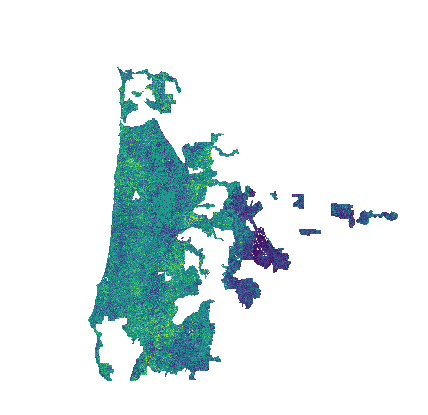

In [50]:
raster_layers, data = create_raster_layer('test', raster_bytes)
m = folium.Map()
for raster_layer in raster_layers:
    raster_layer.add_to(m)
display(m)

In [156]:
minx, miny, maxx, maxy = src.bounds

BoundingBox(left=-2312595.0, bottom=2403795.0, right=-1787685.0, top=2902335.0)

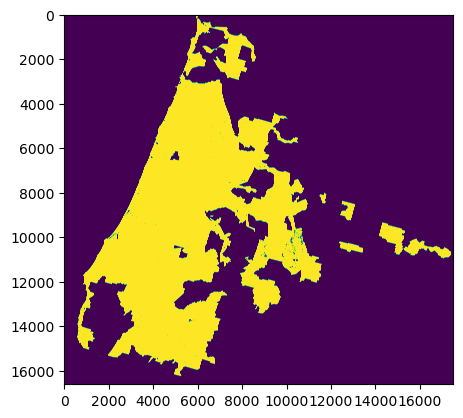

In [151]:
plt.imshow(tif_array)

In [ ]:
import urllib.parse, urllib.request
import concurrent.futures
def fetch_all_features(base_url):
    # Get record extract limit
    url_string = base_url + "?f=json"
    j = urllib.request.urlopen(url_string)
    js = json.load(j)
    max_records_count = int(js["maxRecordCount"])
    max_records_count = min(max_records_count, 800)
    # Get object ids of features
    fields = ""
    where = "1=1"
    url_string = base_url + "/query?where={}&returnIdsOnly=true&f=json".format(where)
    j = urllib.request.urlopen(url_string)
    js = json.load(j)
    id_field = js["objectIdFieldName"]
    id_list = js["objectIds"]
    id_list.sort()
    num_of_records = len(id_list)
    request_number = 0
    # create URLs for requests
    url_strings = []
    for i in range(0, num_of_records, max_records_count):
        request_number += 1
        to_rec = i + (max_records_count - 1)
        if to_rec > num_of_records:
            to_rec = num_of_records - 1
        from_id = id_list[i]
        to_id = id_list[to_rec]
        where = '{} BETWEEN {} AND {}'.format(id_field, from_id, to_id)
        print("  {}: {}".format(request_number, where))
        url_string = base_url + "/query?where={}&returnGeometry=true&outFields={}&f=geojson".format(where, fields)
        url_strings.append(url_string)
    # specify helper function which does the fetching
    def load_features(urlstring):
        succeed = False
        while not succeed:
            try:
                with warnings.catch_warnings(action='ignore'):
                    resp = requests.get(urlstring, verify=False)
                data = resp.json()
                gdf = gpd.GeoDataFrame.from_features(data['features'], crs='EPSG:4326')
                gdf = gdf.loc[gdf['geometry'].is_valid, :]
                succeed = True
                return gdf
            except:
                print ('Failed to load {}'.format(urlstring))
    # thread pool to fetch features
    with concurrent.futures.ThreadPoolExecutor(max_workers=None) as executor:
        features_list = list(executor.map(load_features, url_strings))
    final_gdf = pd.concat(features_list)
    return final_gdf

In [ ]:
fetch_all_features(url)

In [ ]:
def get_geojson(resource):
    url = resource['url'] 
    geojson = requests.get(url).json()
    return geojson
def get_opentopo_geojson(url):
    information = requests.get(url).json()
    json_link = [x['href'] for x in information['links'] if x['rel'] == 'child' and 'raster' not in x['href']]
    if len(json_link) > 0:
        geojson = requests.get(json_link[0]).json()
        feature_collection = {
            "type": "FeatureCollection",
            "features": [
                geojson
            ]
        }
        return feature_collection
def get_raster(resource):
    pass

def create_vector_layer(geojson, dataset_title):
    if 'errors' in geojson:
        return
    else:
        layer = folium.GeoJson(geojson, name=dataset_title)
    return layer

def create_raster_layer():
    pass

def get_layer(dataset):
    dataset_title = dataset['title']
    dataset_id = dataset['id']
    # if layer already exists use it
    if dataset_id in cached_layers.keys():
        print('layer exists, using cached')
        layer = cached_layers[dataset_id]
    else:
        print('creating new layer')
        layer = None
        if dataset['owner_org'] == 'e2d487d1-6973-487c-bb20-a11744d9e1ea': #OpenTopography
            geojson = get_opentopo_geojson(dataset['url'])
            layer = create_vector_layer(geojson, dataset_title)
        else:
            for resource in dataset['resources']:
                if resource['format'] == 'GeoJSON': 
                    geojson = get_geojson(resource)
                    layer = create_vector_layer(geojson, dataset_title)
                    break # only add one layer
                elif resource['format'] == 'GeoTIFF' or resource['format'] == 'TIFF':
                    layer = create_raster_layer(resource)
                    break # only add one layer
                # TODO: make this work?
                elif resource['format'] == 'ArcGIS GeoServices REST API':
                    pass
        if layer:
            print('adding new layer to cache')
            cached_layers[dataset_id] = layer
    return layer
        

In [ ]:
dataset = results[1]
print([(resource['format'], resource['url']) for resource in dataset['resources']])

m = folium.Map()
layer = get_layer(results[1])
layer.add_to(m)
folium.LayerControl().add_to(m)
display(m)

### Vanilla Mode

no streaming, fetched 23776 features in 20.6 seconds

In [ ]:
response = requests.get(url)
json_data = response.json()
print(len(json_data['features']))

### json_stream

 23776 features in 13.5 minutes

In [ ]:
map = folium.Map(location=[37.1661, -119.44944], zoom_start=4)
counter = 0
with requests.get(url, stream=True) as response:
    data = json_stream.requests.load(response)
    # for feature in data['features']:
    #     geometry = feature['geometry']
    #     folium.GeoJson(geometry).add_to(map)
    #     display(map)
    try:
        for feature in data['features']:
            counter += 1
            print(counter)
    except Exception as e:
        print(f'something went wrong: {e}')

In [ ]:
response = json_stream.requests.get(url)
geojson_data = json_stream.load(response.raw)
map = folium.Map(location=[37.1661, -119.44944], zoom_start=4)

# Iterate over the streamed features and add them to the map
for feature in geojson_data['features']:
    geometry = feature['geometry']
    # Add the geometry to the Folium map
    folium.GeoJson(geometry).add_to(map)
    display(map)

In [ ]:
response = requests.get(url)
json_data = response.json()

def extract_geometries(data):
    return {
        "type": "FeatureCollection",
        "features": [
            {"type": "Feature", "geometry": feature["geometry"]}
            for feature in data.get("features", [])
        ]
    }
geometries = extract_geometries(json_data['features'])

In [ ]:
import gzip
from io import BytesIO
with requests.get(url, stream=True) as response:
    if response.status_code ==200:
        if response.headers.get('Content-Encoding') == 'gzip':
            # Decompress the gzip content
            buffer = BytesIO(response.content)
            with gzip.GzipFile(fileobj=buffer) as decompressed_file:
                    # Parse the decompressed content as JSON
                    for item in ijson.items(decompressed_file, 'item'):
                        print(item)
        